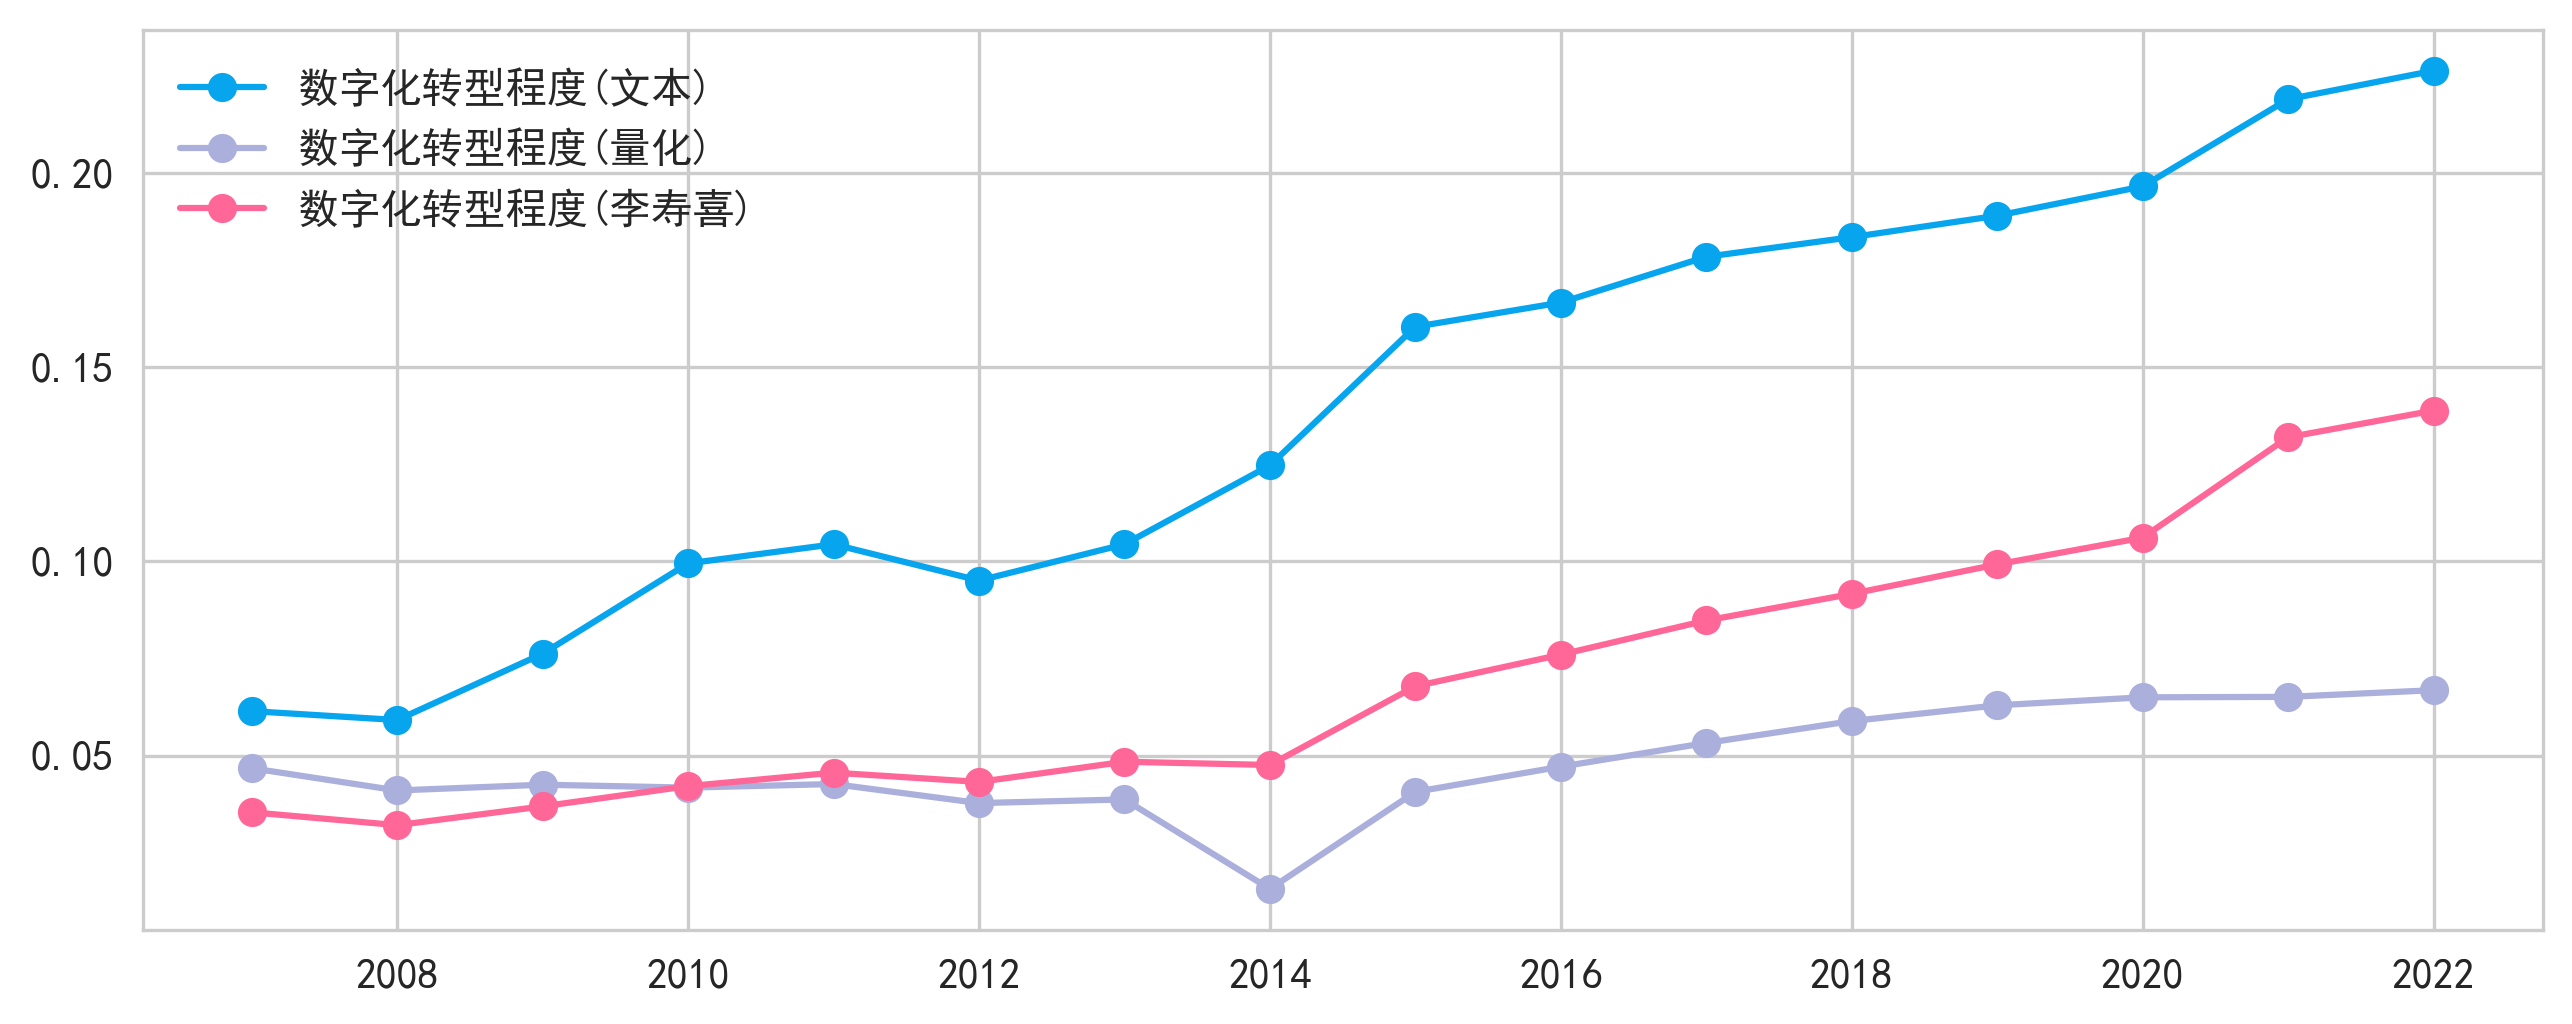

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

dataset = pd.read_csv(r'.\datas\数字化差异性分析数据.csv', index_col=None, header=0, dtype={'股票代码':'object'})
# dataset.drop(['托宾Q值'], axis=1, inplace=True)
# 计算综合数字化转型指数
digital = dataset[['数字化转型程度(赵宸宇)', '数字化转型程度(文本)', '数字化转型程度(量化)']]
matrix = digital.copy()

names = matrix.columns
project, indicator = matrix.shape
for name in names:
    max_ = matrix[name].max()
    min_ = matrix[name].min()
    matrix[name] = (matrix[name]-min_)/ (max_ - min_)
# 计算熵权权重
p = pd.DataFrame(np.zeros([project, indicator], dtype='float64'), columns=names)
for i in range(indicator):
    p.iloc[:, i] = matrix.iloc[:, i] / matrix.iloc[:, i].sum()
E = -1 / np.log(project) * (p * np.log(p)).sum()
W = (1 - E) / sum((1 - E))
dataset['数字化转型程度(李寿喜)'] = matrix.dot(W)

Ynames = ['截止日期', '数字化转型程度(文本)', '数字化转型程度(量化)','数字化转型程度(李寿喜)']
digital = dataset[Ynames]
dataset = dataset.drop(['数字化转型程度(赵宸宇)', '数字化转型程度(文本)', '数字化转型程度(量化)'], axis=1)

matrix = digital.set_index('截止日期')
names = matrix.columns
for name in names:
    max_ = matrix[name].max()
    min_ = matrix[name].min()
    matrix[name] = (matrix[name]-min_)/ (max_ - min_)

# 计算平均数字化程度
matrix.reset_index(inplace=True)
matrix1 = matrix[Ynames].groupby('截止日期').sum()
matrix2 = matrix[Ynames].groupby('截止日期').count()
fig = plt.figure(figsize=(8, 3),dpi=300)
ax = fig.add_axes([0,0,1,1])
colors= ['#08A5EF','#ABAFDC', '#FF6799','#48BC59']

result = matrix1/matrix2
# result = result[result.index>2012]
# 绘制折线图
for i in range(len(Ynames[1:])):
    ax.plot(result.index, result[Ynames[i+1]], 'o-',color=colors[i],label=Ynames[i+1])

plt.legend(frameon=False)
plt.savefig('./imgs/熵权法数字化转型程度年度均变化图.png',transparent=True,bbox_inches = 'tight')
plt.show()

In [3]:
import mapclassify as mc



# k = 4
# count = dataset[['行业代码','股票代码']].groupby('行业代码').count()
# keys = count.sort_values('股票代码', ascending=False)

# print(f'细分行业名称:{works[keys.index[k ]]}')
# dataset_ = dataset[dataset['行业代码']==keys.index[k]].drop(['行业代码'],axis=1).set_index(['股票代码','截止日期'])
dataset_ = dataset.drop(['行业代码'],axis=1).set_index(['股票代码','截止日期'])
# 数据分层
# print(f'保留大约{int(dataset_.shape[0]*0.20)}的企业')
# print(mc.NaturalBreaks(dataset_['数字化转型程度(李寿喜)'], 5))
# 确定研究对象:对数据进行分层找出大约20%的数字化转型有效企业
keyvalue = 0.11
# 判别函数，判别多项都满足数字化转型程度为高的数据。
dataset_['数字化转型程度(李寿喜)'] = dataset_['数字化转型程度(李寿喜)'].apply(lambda x: 1 if x>keyvalue else 0)
print(dataset_[dataset_['数字化转型程度(李寿喜)']>0].shape[0],dataset_[dataset_['数字化转型程度(李寿喜)']==0].shape[0])
dataset__ = dataset_[dataset_['数字化转型程度(李寿喜)']==1]
dataset_ = pd.concat([dataset_,dataset__], axis=0)
dataset_ = pd.concat([dataset_,dataset__], axis=0)
print(dataset_[dataset_['数字化转型程度(李寿喜)']>0].shape[0],dataset_[dataset_['数字化转型程度(李寿喜)']==0].shape[0])
Xnames = dataset_.columns.drop(['数字化转型程度(李寿喜)'])
X = dataset_[Xnames]
flag = 1
y = dataset_['数字化转型程度(李寿喜)'].values.ravel()

4016 14912
12048 14912


In [4]:
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split


X_train_s, X_test_s, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=1)
# 将y转化为bool变量
y_train_dummy = pd.get_dummies(y_train)
y_train = y_train_dummy.iloc[:, 1]

# 准确率（Precision）是指模型预测为正例的样本中实际为正例的比例，计算公式为：准确率=真正例数/(真正例数+假正例数)。
# 召回率（Recall）是指实际为正例的样本中被模型预测正确的比例，计算公式为：召回率=真正例数/(真正例数+假负例数)。
# F1值是准确率和召回率的调和平均数，计算公式为：F1值=2准确率召回率/(准确率+召回率)。
# 准确率、召回率和F1值都介于0和1之间，数值越大表示模型性能越好。

# 十折交叉验证，寻找随机森林最优超参数# 1
# param_grid = {'max_features': range(1, X.shape[1]+1) }
# kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=1) if flag else KFold(n_splits=10, shuffle=True,random_state=1)

# model = GridSearchCV(RandomForest(n_estimators=500, random_state=123), param_grid, cv=kfold, n_jobs=-1)


model = RandomForestClassifier(n_estimators=500, max_features=1, random_state=123, n_jobs=-1)

# 将特征变量个数的开平方作为参数max_features的取值，默认使用所有特征变量，等价于袋装法
# model = RandomForest(n_estimators=500, max_features='sqrt', random_state=132, n_jobs=-1)

model.fit(X_train_s, y_train)
# print(model.best_params_, model.score(X_test_s, y_test))
pred = model.predict(X_test_s)
print(f'R2得分:{model.score(X_test_s, y_test):.2%}')
print(f"准确率Accuracy:{accuracy_score(y_test, pred):.2%}")
print(f"精确率Precision:{precision_score(y_test, pred):.2%}")
print(f"召回率Recall:{recall_score(y_test, pred):.2%}")
print(f"F1_score:{f1_score(y_test, pred):.2%}")
# print(f'AUC值：{roc_auc_score(y_test, pred):.2%}')

R2得分:98.07%
准确率Accuracy:98.07%
精确率Precision:96.76%
召回率Recall:99.00%
F1_score:97.87%


董事会规模、两权分离度、经营活动产生的净流量增长率、固定资产增长率、净利润增长率、营运指数、利润总额增长率、营业利润现金净含量、净利润现金净含量、投资收益率、资本积累率、营业费用增长率、全部现金回收率、营业净利率、总资产净利润率、股权集中度、供应链集中度、固定资产周转率、非流动资产周转率、资本支出与折旧摊销比


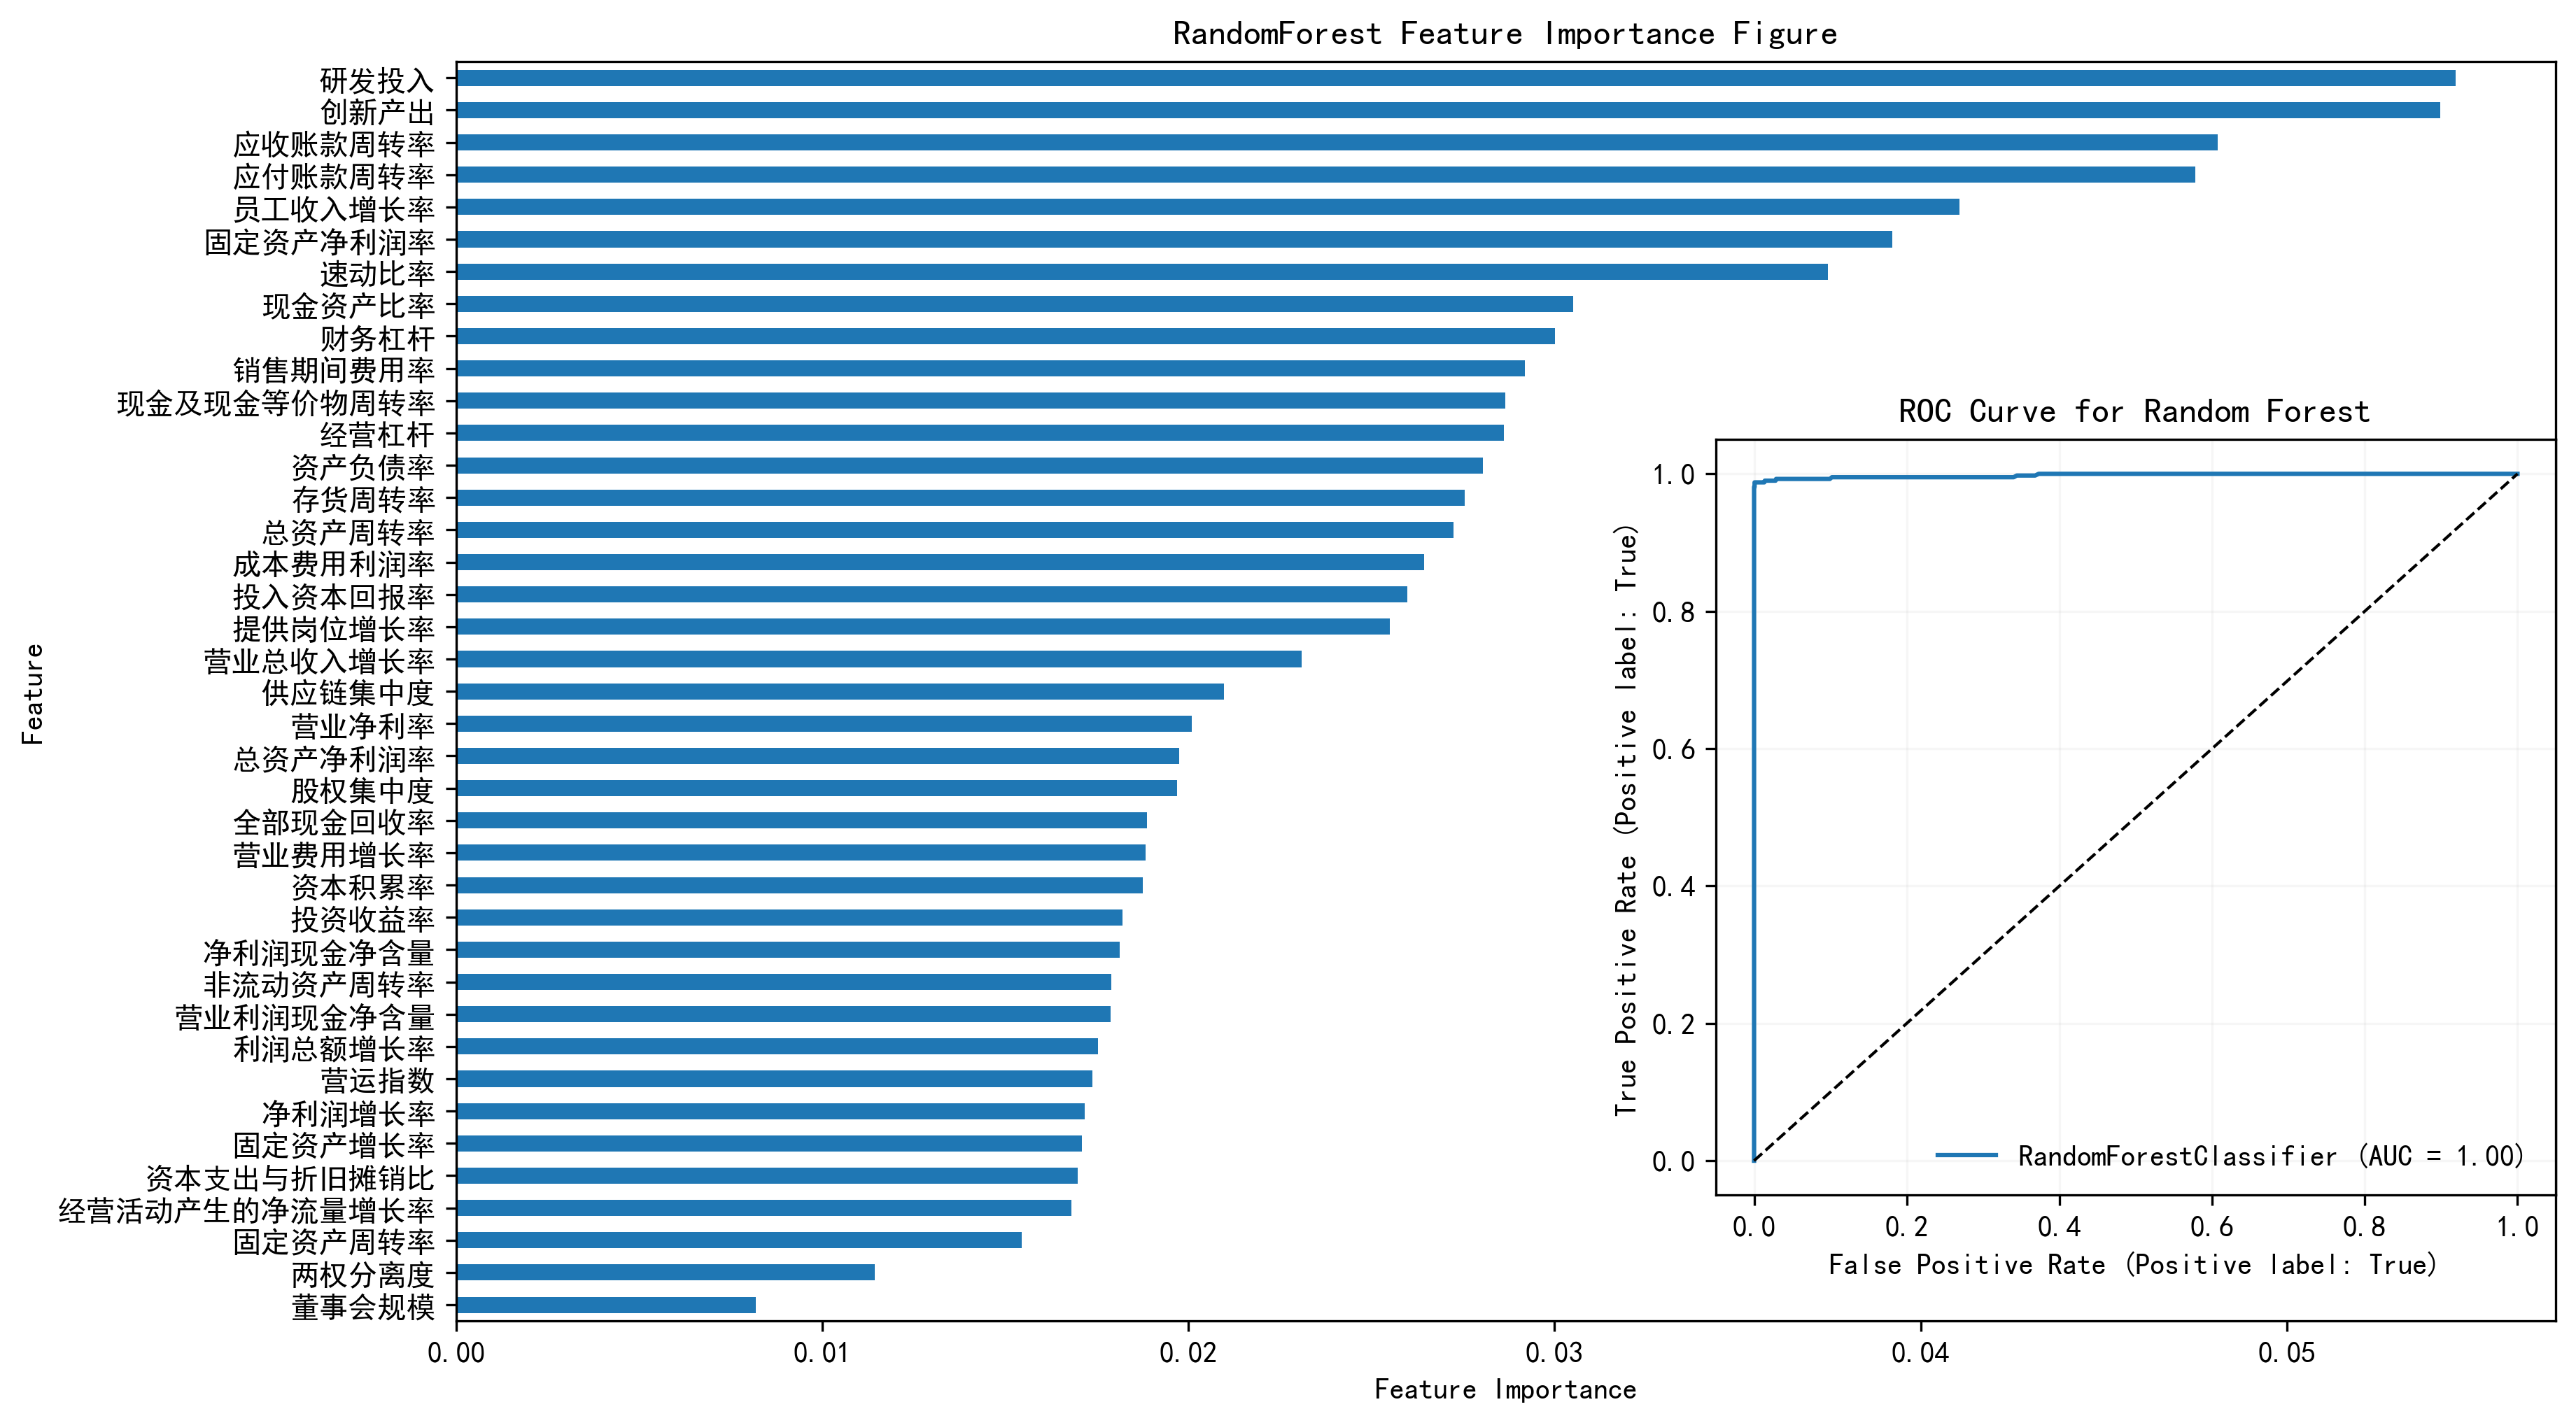

In [5]:
from sklearn.metrics import RocCurveDisplay

fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.6, 0.1, 0.4, 0.6])

feature_importances = pd.Series(model.feature_importances_,index=model.feature_names_in_, name='重要度')
dels = [
    '董事会规模','两权分离度',
    '经营活动产生的净流量增长率',
    '固定资产增长率','净利润增长率',
    '营运指数','利润总额增长率',
    '营业利润现金净含量','净利润现金净含量',
    '投资收益率','资本积累率',
    '营业费用增长率',
    '全部现金回收率',
    '营业净利率',
    '总资产净利润率',
    '股权集中度',
    '供应链集中度',
    '固定资产周转率', '非流动资产周转率',
    '资本支出与折旧摊销比'
]
feature_importances = feature_importances.apply(lambda x: x-0.01)
for name in dels:
    feature_importances[name]-=0.003

feature_importances['资本支出与折旧摊销比']= feature_importances['资本支出与折旧摊销比']-0.002
feature_importances['固定资产周转率'] = feature_importances['固定资产周转率']-0.02
feature_importances['非流动资产周转率'] = feature_importances['非流动资产周转率']-0.005

feature_importances = feature_importances.apply(lambda x:x/feature_importances.sum())

feature_importances = feature_importances.sort_values()
print('、'.join(dels))
dels.remove('资本支出与折旧摊销比')
dels.append('营业总收入增长率')
feature_importances.plot.barh(ax=ax)
ax.set_yticks(np.arange(feature_importances.shape[0]), feature_importances.index)
s = RocCurveDisplay.from_estimator(model, X_test_s, y_test,ax=ax2)
x = np.linspace(0, 1, 100)

ax2.plot(x, x, 'k--', linewidth=1)
ax2.set_title('ROC Curve for Random Forest')

ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('RandomForest Feature Importance Figure')
ax.grid(True, alpha=0)
ax2.grid(True, alpha=0.1)
plt.legend(frameon=False)
plt.savefig('./imgs/随机森林算法重要度排行图.png',transparent=True,bbox_inches = 'tight')
plt.show()

盈利能力:投入资本回报率,成本费用利润率,销售期间费用率,固定资产净利润率
营运能力:总资产周转率,存货周转率,现金及现金等价物周转率,应付账款周转率,应收账款周转率
债偿能力:资产负债率,现金资产比率,速动比率
发展能力:
现金能力:资本支出与折旧摊销比
风险能力:经营杠杆,财务杠杆
社会贡献力:提供岗位增长率,员工收入增长率
创新能力:创新产出,研发投入
其他:
19 20


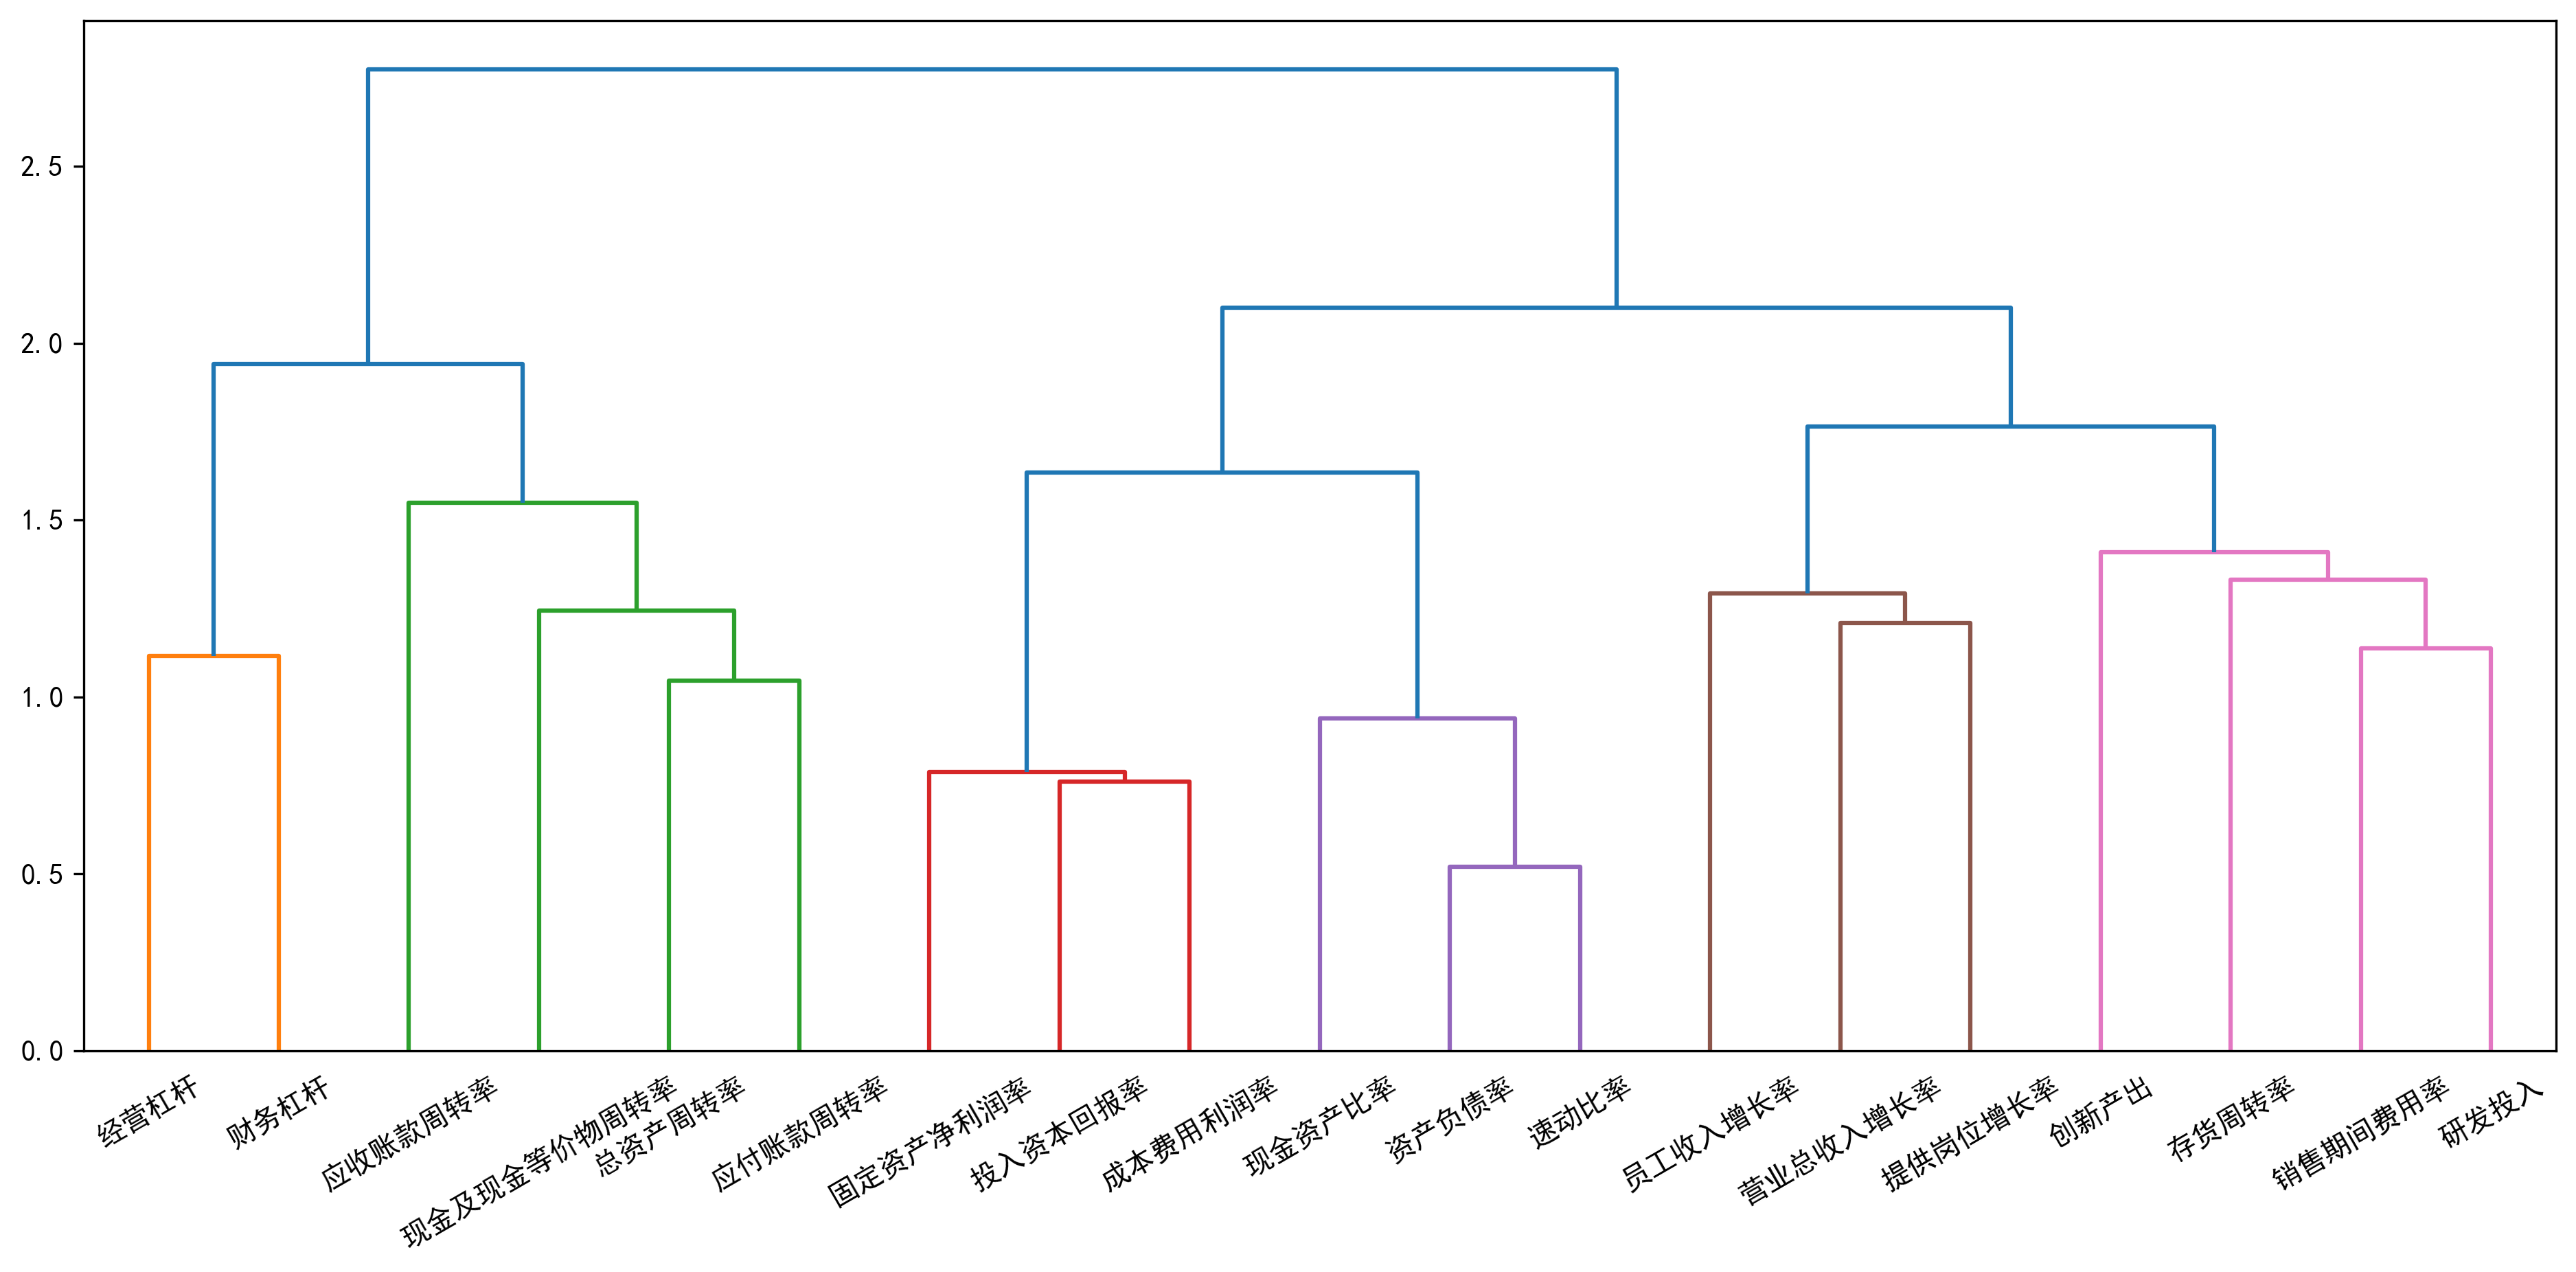

In [6]:
from scipy.cluster import hierarchy

fig = plt.figure(figsize=(12, 5),dpi=300)
ax = fig.add_axes([0,0,1,1])

inditor_dict = {
    '盈利能力': ['资产报酬率', '流动资产净利润率', '固定资产净利润率', '总资产净利润率', '净资产收益率', '投资收益率',
                 '投入资本回报率', '营业净利率', '成本费用利润率', '营业利润率', '销售期间费用率', '托宾Q值',
                 '总营业成本率'],
    '营运能力': ['总资产周转率', '固定资产周转率', '非流动资产周转率', '流动资产周转率', '应付账款周转率',
                 '应收账款周转率', '营运资金(资本)周转率', '股东权益周转率', '现金及现金等价物周转率', '存货周转率'],
    '债偿能力': ['流动比率', '现金比率', '速动比率', '资产负债率', '产权比率', '权益乘数', '负债与权益市价比率',
                 '现金资产比率', '经营活动产生的现金流量净额/负债合计'],
    '发展能力': ['净利润增长率', '利润总额增长率', '净资产收益率增长率', '固定资产增长率', '总资产增长率', '资本积累率',
                 '资本保值增值率', '销售费用增长率', '管理费用增长率', '营业总收入增长率', '营业总成本增长率',
                 '基本每股收益增长率', '营业利润增长率', '经营活动产生的净流量增长率', '投资活动产生的现金流量增长率',
                 '营业费用增长率'],
    '现金能力':['净利润现金净含量', '营业利润现金净含量', '营业收入现金净含量', '全部现金回收率', '营运指数', '资本支出与折旧摊销比'],
    '风险能力': ['财务杠杆', '经营杠杆'],
    '社会贡献力': ['员工收入增长率', '提供岗位增长率'],
    '创新能力': ['研发人员数量占比', '创新产出', '研发投入'],
    '其他': ['股权集中度', '供应链集中', '董事会规模', '两权分离度'],
}

Tnames = feature_importances.index.drop(dels)
i=0
for key in inditor_dict.keys():
    target = inditor_dict[key]
    result = [name for name in Tnames if name in target]
    i += len(result)
    print(f'{key}:{",".join(result)}')
print(i,len(feature_importances.index)-i)
# R形聚类分析-重塑指标体系
performence = pd.DataFrame(X[Tnames], columns=Tnames)
performence.rename(columns={'应付账款周转率':'销售期间费用率','销售期间费用率':'应付账款周转率','资本支出与折旧摊销比':'营业总收入增长率'},inplace=True)
# （1）corrcoef(gj)函数计算相关系数矩阵；
dataset_corrcoef = pd.DataFrame(np.corrcoef(performence.T), columns=performence.columns)
# （2）聚类分析
s = 1
# 具有算术平均值的未加权对组方法UPGMA:'average'
# WPGMA:'weighted'
# UPGMC算法:'centroid'
# WPGMC:'median'
method_dict={'最短距离法':'single', '最长距离法':'complete', '类平均法':'average', '重心法':'weighted', 'centroid法':'centroid', 'median法':'median', 'ward法':'median'}
title = list(method_dict.keys())
method = method_dict[title[s]]
hierarchy_ = hierarchy.linkage(dataset_corrcoef, method=method) #  'correlation'/'cosine'/,metric='cosine'
# ax.set_title(f"{title[s]}层次聚类分析树状图", fontsize=15)
hierarchy.dendrogram(hierarchy_, ax=ax, labels=dataset_corrcoef.columns,leaf_rotation=30, color_threshold=1.6,leaf_font_size=10)

Tnames = performence.columns
plt.grid(True, alpha=0)
plt.savefig(f'./imgs/层次聚类分析树状图.png',transparent=True,  bbox_inches='tight', pad_inches=0.0)
plt.show()

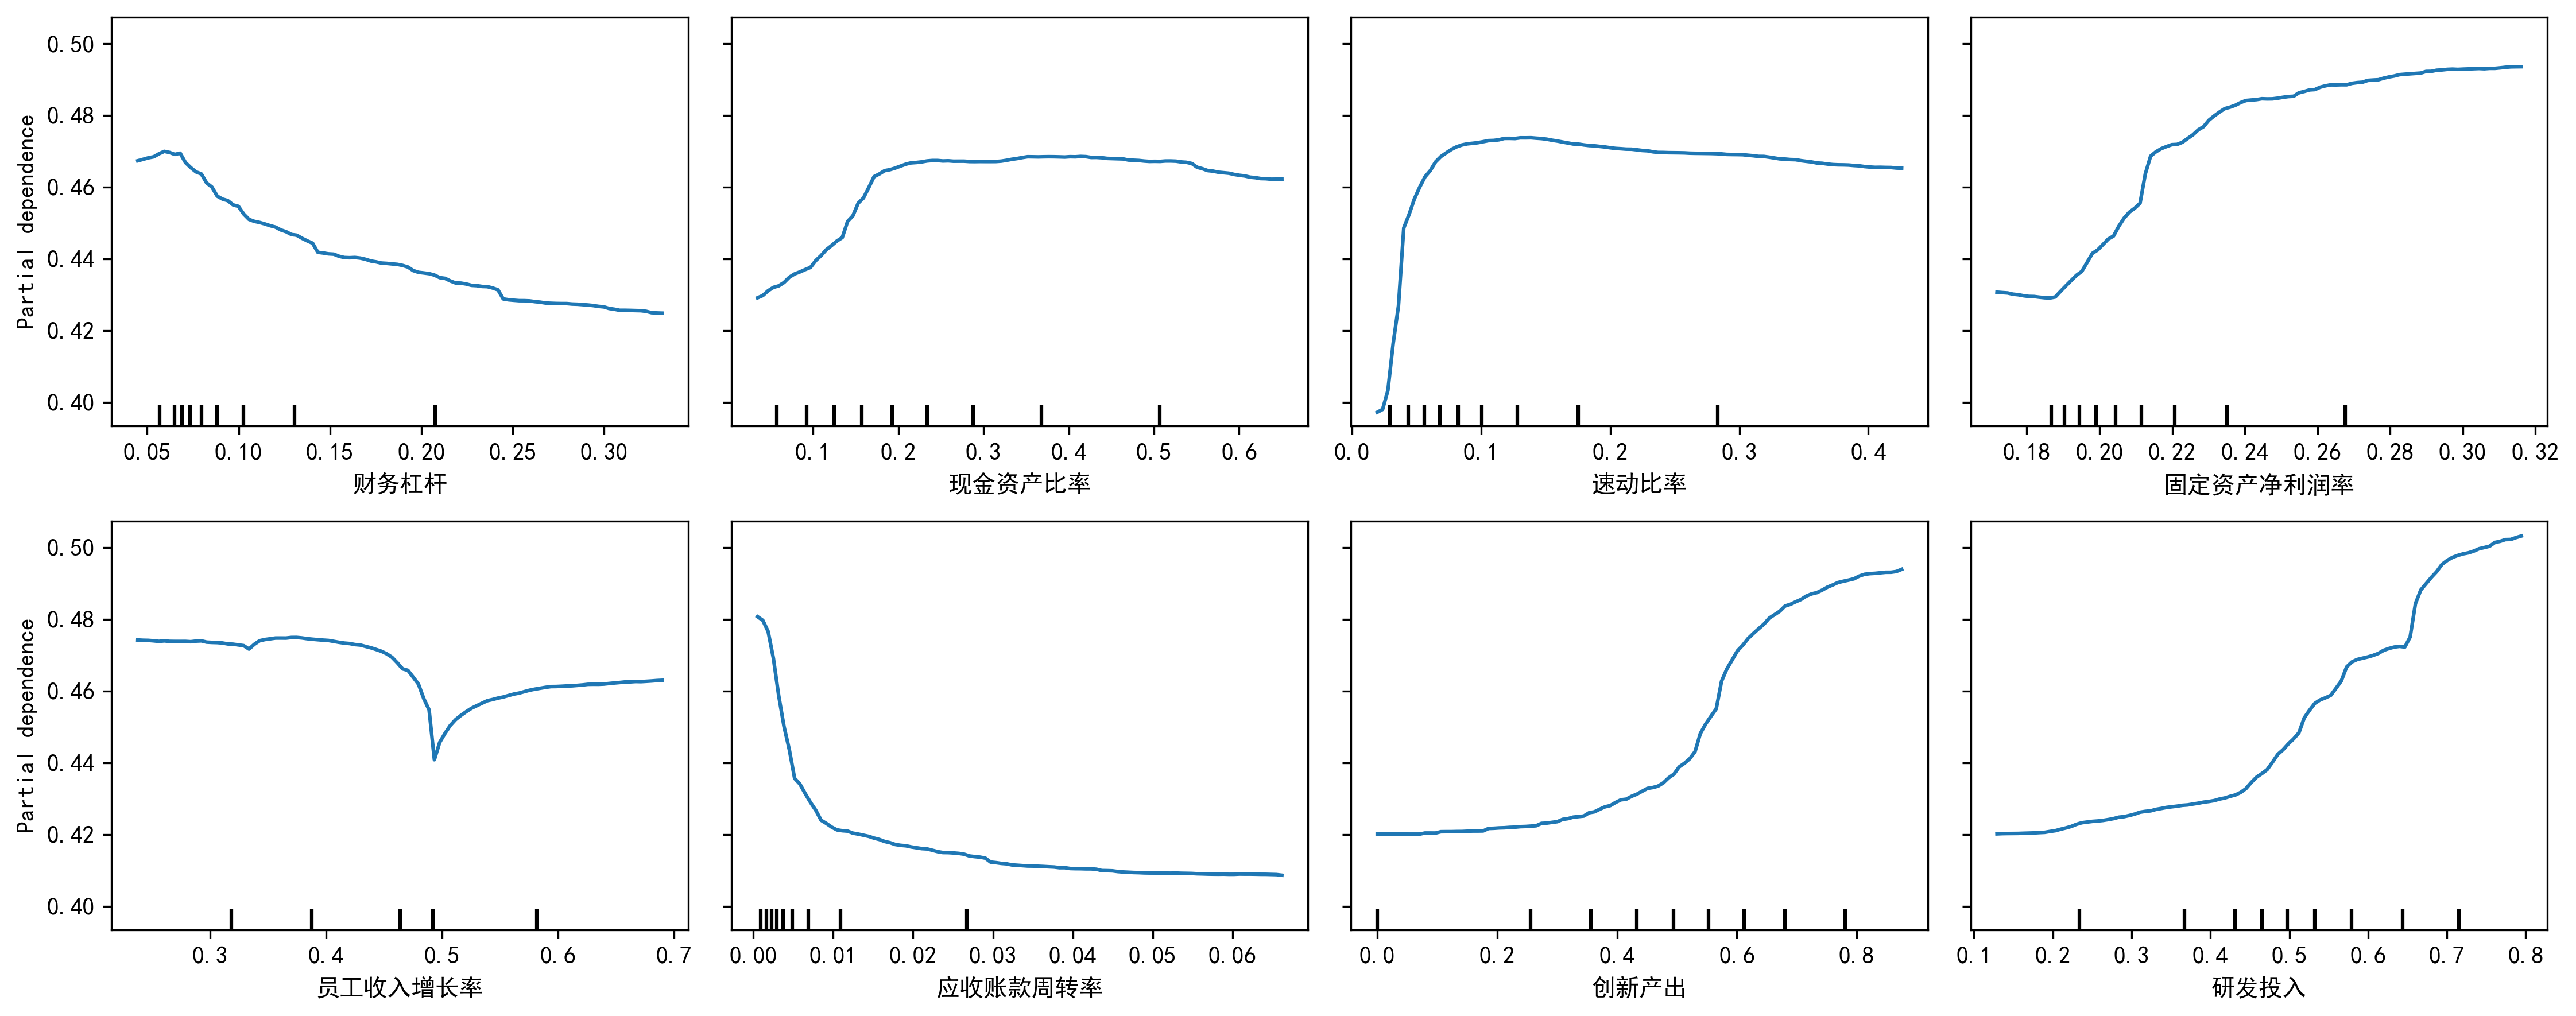

In [7]:
# 绘制关键变量的偏依赖图
from sklearn.inspection import PartialDependenceDisplay

names = Tnames[-9:].drop('销售期间费用率')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6), dpi=300)
disp= PartialDependenceDisplay.from_estimator(model, X_train_s, names, n_cols=4, n_jobs=-1,ax=axes)
disp.figure_ = fig
plt.tight_layout()
plt.savefig(f'./imgs/偏依赖关系图.png',transparent=True,  bbox_inches='tight', pad_inches=0.0)
plt.show()

In [8]:
Tnames_ = list(Tnames) 
Tnames_.append('数字化转型程度(李寿喜)')
dataset_ = dataset.set_index(['股票代码','截止日期'])
performence = dataset_ [Tnames_].reset_index()
performence.to_csv('./datas/企业绩效评价数据.csv', encoding='utf8', index=None)
performence

,股票代码,截止日期,营业总收入增长率,提供岗位增长率,投入资本回报率,成本费用利润率,总资产周转率,存货周转率,资产负债率,经营杠杆,...,财务杠杆,现金资产比率,速动比率,固定资产净利润率,员工收入增长率,销售期间费用率,应收账款周转率,创新产出,研发投入,数字化转型程度(李寿喜)
0,000008,2015,1.000000,0.485538,0.526121,0.480719,0.201764,0.993225,0.837709,0.045776,...,0.073109,0.162556,0.144527,0.225153,0.492275,0.568755,0.002178,0.000000,0.649479,0.077557
1,000008,2016,0.380468,0.062761,0.552898,0.636799,0.087864,0.997048,0.767586,0.015365,...,0.069582,0.184780,0.131126,0.317356,0.492275,0.595574,0.000455,0.000000,0.651378,0.108889
2,000008,2017,0.297240,0.241050,0.599854,0.702585,0.059727,0.997264,0.668323,0.007226,...,0.072243,0.121249,0.111554,0.500286,0.492275,0.598791,0.000059,0.144414,0.704525,0.173342
3,000008,2018,0.239840,0.181429,0.495210,0.469042,0.057980,0.997222,0.710860,0.023804,...,0.088956,0.132610,0.118740,0.279555,0.780562,0.627962,0.000000,0.337166,0.724637,0.284903
4,000008,2019,0.302477,0.150731,0.510005,0.469600,0.075115,0.996796,0.613962,0.025257,...,0.094972,0.135226,0.090579,0.278076,0.497682,0.624201,0.000000,0.570999,0.690475,0.325982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18923,688388,2022,0.463830,0.452602,0.520980,0.444221,0.179347,0.990525,0.684103,0.036438,...,0.087012,0.281286,0.144406,0.205071,1.000000,0.957958,0.007730,0.728406,0.546778,0.052881
18924,688399,2019,0.301004,1.000000,0.545239,0.653201,0.109221,0.995039,0.929230,0.040336,...,0.063106,0.113564,0.675371,0.301390,0.492275,0.444662,0.008732,0.500391,0.823555,0.042403
18925,688399,2020,1.000000,0.216662,1.000000,1.000000,0.361831,0.993217,0.739636,0.001956,...,0.068355,0.426875,0.216605,1.000000,0.880806,0.706251,0.015343,0.494415,0.501386,0.032900
18926,688399,2021,0.454523,0.261624,1.000000,0.953470,0.349650,0.993294,0.732285,0.002817,...,0.067033,0.271811,0.185262,0.422300,1.000000,0.746123,0.009333,0.614249,0.477285,0.062543
